## Шаг 1. Загрузка данных и их предобработка

In [ ]:
!pip install psycopg2-binary sqlalchemy phik matplotlib numpy pandas python-dotenv ipython gdown

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import numpy as np
import os
from dotenv import load_dotenv

```sql
# вводные данные база данных postgres

# CREATE SCHEMA afisha AUTHORIZATION praktikum_admin;
# CREATE TABLE regions ( region_id int4 NOT NULL, region_name varchar(50) NULL, CONSTRAINT regions_pkey PRIMARY KEY (region_id));
# CREATE TABLE venues ( venue_id int4 NOT NULL, venue_name varchar(64) NULL, address varchar(50) NULL, CONSTRAINT venues_pkey PRIMARY KEY (venue_id));
# CREATE TABLE city ( city_id int4 NOT NULL, city_name varchar(50) NULL, region_id int4 NULL, CONSTRAINT city_pkey PRIMARY KEY (city_id), CONSTRAINT city_region_id_fkey FOREIGN KEY (region_id) REFERENCES regions(region_id));
# CREATE TABLE events ( event_id int4 NOT NULL, event_name_code varchar(50) NULL, event_type_description varchar(50) NULL, event_type_main varchar(50) NULL, organizers varchar(50) NULL, city_id int4 NULL, venue_id int4 NULL, CONSTRAINT events_pkey PRIMARY KEY (event_id), CONSTRAINT events_city_id_fkey FOREIGN KEY (city_id) REFERENCES city(city_id), CONSTRAINT events_venue_id_fkey FOREIGN KEY (venue_id) REFERENCES venues(venue_id));
# CREATE TABLE purchases ( order_id int4 NOT NULL, user_id varchar(50) NULL, created_dt_msk timestamp NULL, created_ts_msk timestamp NULL, event_id int4 NULL, cinema_circuit varchar(50) NULL, age_limit int4 NULL, currency_code varchar(50) NULL, device_type_canonical varchar(50) NULL, revenue float4 NULL, service_name varchar(50) NULL, tickets_count int4 NULL, total float4 NULL, CONSTRAINT purchases_pkey PRIMARY KEY (order_id), CONSTRAINT purchases_event_id_fkey FOREIGN KEY (event_id) REFERENCES events(event_id), CONSTRAINT purchases_event_id_fkey1 FOREIGN KEY (event_id) REFERENCES events(event_id));

# Описание данных
# Схема afisha базы данных data-analyst-afisha содержит пять таблиц.

# Таблица purchases
# Содержит информацию о заказах билетов:
# order_id — идентификатор заказа;
# user_id — идентификатор пользователя, совершившего заказ;
# created_dt_msk — дата создания заказа по московскому времени;
# created_ts_msk — дата и время создания заказа по московскому времени;
# event_id — идентификатор мероприятия из таблицы events;
# cinema_circuit — сеть кинотеатров, где проходит мероприятие. Если оно проходит не в кинотеатре, то здесь будет значение нет;
# age_limit — возрастное ограничение мероприятия;
# currency_code — валюта оплаты;
# device_type_canonical — тип устройства, с которого был оформлен заказ (например, mobile — мобильные устройства, desktop — компьютеры);
# revenue — выручка от заказа;
# service_name — название билетного оператора;
# tickets_count — количество купленных билетов;
# total — общая сумма заказа.

# Таблица events
# Содержит данные о мероприятиях, доступных на платформе:
# event_id — идентификатор мероприятия.
# event_name_code — название мероприятия в закодированном виде.
# event_type_description — описание мероприятия.
# event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее)
# organizers — организаторы мероприятия.
# city_id — идентификатор города проведения мероприятия из таблицы cities.
# venue_id — идентификатор площадки проведения мероприятия из таблицы venues.

# Таблица venues
# Содержит сведения о площадках проведения мероприятий:
# venue_id — идентификатор площадки;
# venue_name — название площадки;
# address — адрес площадки.

# Таблица city
# Содержит список городов, относящихся к регионам:
# city_id — идентификатор города;
# city_name — название города;
# region_id — идентификатор региона, в котором расположен город, из таблицы regions.

# Таблица regions
# Содержит список регионов, в которых проводятся мероприятия:
# region_id — идентификатор региона;
# region_name — название региона.
```



###Задача 1.1: Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных data-analyst-afisha:

In [ ]:
load_dotenv()

DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
rates_url = "https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv"

engine = create_engine(connection_string)
query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.total,
    (p.created_dt_msk::DATE -
        LAG(p.created_dt_msk::DATE) OVER (
            PARTITION BY p.user_id
            ORDER BY p.created_dt_msk::DATE ASC
        )
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name,
    p.cinema_circuit
FROM afisha.purchases p
JOIN afisha.events e   ON p.event_id = e.event_id
JOIN afisha.city c    ON e.city_id = c.city_id
JOIN afisha.regions r   ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile','desktop')
    AND e.event_type_main <> 'фильм'
ORDER BY p.user_id ASC, p.created_ts_msk ASC
'''

df = pd.read_sql_query(query, con=engine)

### Задача 1.2: Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.
- Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.
- Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

Отфильтровать данные:
- Можно исключить дубли 1 города (исходя из предыдущих анализов), но фактически на результат это не влияет.
- Исключить данные с отрицательными значениями цены (но в рамках данного курса это не требуется)
- Исключить данные превышающие среднее значение цены билета более чем в 10 раз в виду возможной некорректности данных

## Шаг 2. Предобработка данных
Выполните все стандартные действия по предобработке данных:


### Задача 2.1. Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — final_tickets_tenge_df.csv. Его можно скачать по ссылке. Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец revenue_rub.


In [184]:
def convert_fields_to_rub(
    df,
    rates_csv_url,             # ссылка на CSV с курсами разных валют к рублю
    df_target_fields,          # список ваших столбцов, которые нужно привести к рублям
    df_new_fields,             # имена новых столбцов для результата
    df_datetime_field,         # имя столбца с датой в df
    df_currency_field,         # имя столбца с валютой в df
    rates_datetime_field,      # имя столбца с датой в rates_df
    rates_currency_field       # имя столбца с кодом валюты в rates_df
):
    df=df.copy()

    # 1. Загрузка справочника курсов
    rates_df = pd.read_csv(rates_csv_url, parse_dates=[rates_datetime_field])
    # Рассчитываем курс за 1 единицу для каждой строки
    rates_df['rate_to_rub'] = rates_df['curs'] / rates_df['nominal']

    # 2. Приведение дат к единому типу для merge по дате:
    df = df.copy()
    if pd.api.types.is_datetime64_any_dtype(df[df_datetime_field]):
        df['datetime_field_tmp'] = pd.to_datetime(df[df_datetime_field]).dt.normalize()
        rates_df['datetime_field_tmp'] = pd.to_datetime(rates_df[rates_datetime_field]).dt.normalize()
    else:
        df['datetime_field_tmp'] = pd.to_datetime(df[df_datetime_field]).dt.date
        rates_df['datetime_field_tmp'] = pd.to_datetime(rates_df[rates_datetime_field]).dt.date

    # 3. Слияние по дате и валюте (left join)
    # Чтобы получить нужный курс, добавляем валюту в ключ соединения:
    merged_df = df.merge(
        rates_df[['datetime_field_tmp', rates_currency_field, 'rate_to_rub']],
        how='left',
        left_on=['datetime_field_tmp', df_currency_field],
        right_on=['datetime_field_tmp', rates_currency_field]
    )

    # 4. Добавление новых столбцов с конвертацией
    for src, dst in zip(df_target_fields, df_new_fields):
        merged_df[dst] = merged_df.apply(
            lambda row: row[src] * row['rate_to_rub'] if not pd.isnull(row['rate_to_rub']) else row[src],
            axis=1
        )

    # 5. Очистка временных столбцов
    merged_df = merged_df.drop(columns=['datetime_field_tmp', 'rate_to_rub', rates_currency_field])
    return merged_df

df_mix = convert_fields_to_rub(
    df,
    rates_url,
    ['revenue','total'],
    ['revenue_rub','total_rub'],
    'order_dt',
    'currency_code',
    'data',
    'cdx'
)
display(HTML(df_mix[:10].to_html()))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,total,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,cinema_circuit,revenue_rub,total_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,10870.99,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,нет,1521.94,10870.99
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,2067.51,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,нет,289.45,2067.51
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,13984.16,75.00,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,нет,1258.57,13984.16
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,212.28,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,нет,8.49,212.28
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,10695.43,83.00,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,нет,1390.41,10695.43
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,8206.70,19.00,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск,нет,902.74,8206.70
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,9178.26,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск,нет,917.83,9178.26
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,955.52,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск,нет,47.78,955.52
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,2494.73,16.00,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск,нет,74.84,2494.73
9,000cf0659a9f40f,mobile,6818017,2024-06-20,2024-06-20 10:35:26,rub,1421.91,4,17773.87,0.00,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,нет,1421.91,17773.87


### Задача 2.2

#### 2.2.1 Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце days_since_prev.

In [185]:
def missing_summary(df):
    missing = df.isnull().sum()
    percent = 100 * missing / len(df)
    result = pd.DataFrame({
        'column': missing.index,
        'missing_count': missing.values,
        'missing_percent': percent.values
    })
    return result.sort_values('missing_count', ascending=False)

summary_missing = missing_summary(df_mix)
display(HTML(summary_missing.to_html()))

,column,missing_count,missing_percent
9,days_since_prev,21933,7.55
1,device_type_canonical,0,0.00
0,user_id,0,0.00
2,order_id,0,0.00
3,order_dt,0,0.00
5,currency_code,0,0.00
4,order_ts,0,0.00
6,revenue,0,0.00
7,tickets_count,0,0.00
8,total,0,0.00


#### 2.2.2 Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.

In [186]:
def optimize_types(df):
    df=df.copy()
    # Дата и время: преобразовать к pandas datetime
    datetime_columns = ['order_dt', 'order_ts', 'created_dt_msk', 'created_ts_msk']
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Целые числа: переводить в int32 (экономия памяти)
    int_columns = ['order_id', 'event_id', 'tickets_count', 'age_limit', 'region_id', 'city_id', 'venue_id', 'days_since_prev']
    for col in int_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int32')

    # Вещественные числа: переводить в float32 и округлить до сотых
    float_columns = ['revenue', 'total', 'revenue_rub', 'total_rub']
    for col in float_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

    # Для категориальных столбцов: уместно использовать type 'category'
    cat_columns = ['device_type_canonical', 'service_name', 'cinema_circuit', 'currency_code',
                  'event_type_main', 'region_name', 'city_name']
    for col in cat_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')

    return df
pd.options.display.float_format = '{:.2f}'.format
df_opt = optimize_types(df_mix)
display(HTML(df_opt[:10].to_html()))

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,total,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,cinema_circuit,revenue_rub,total_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,10870.99,<NA>,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,нет,1521.94,10870.99
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,2067.51,<NA>,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,нет,289.45,2067.51
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,13984.16,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,нет,1258.57,13984.16
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,212.28,<NA>,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,нет,8.49,212.28
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,10695.43,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,нет,1390.41,10695.43
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,8206.70,19,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск,нет,902.74,8206.70
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,9178.26,<NA>,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск,нет,917.83,9178.26
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,955.52,<NA>,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск,нет,47.78,955.52
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,2494.73,16,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск,нет,74.84,2494.73
9,000cf0659a9f40f,mobile,6818017,2024-06-20,2024-06-20 10:35:26,rub,1421.91,4,17773.87,0,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье,нет,1421.91,17773.87


##### 2.2.3.1 Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.

In [187]:
def category_summary(df, categorical_columns):
    result = []
    for col in categorical_columns:
        vc = df[col].value_counts(dropna=False)
        for cat, cnt in vc.items():
            result.append({'column': col, 'category': cat, 'count': cnt})
    return pd.DataFrame(result).sort_values(['column','count'], ascending=[True, False])

# Список категориальных столбцов
categorical_columns = [
    'device_type_canonical', 'service_name', 'cinema_circuit', 'currency_code',
    'event_type_main', 'region_name', 'city_name'
]

# Сводная таблица:
summary_df = category_summary(df_opt, categorical_columns)
display(HTML(summary_df.to_html(index=False)))

column,category,count
cinema_circuit,нет,289213
cinema_circuit,Другое,1261
cinema_circuit,КиноСити,122
cinema_circuit,Киномакс,7
cinema_circuit,Москино,7
cinema_circuit,ЦентрФильм,1
city_name,Глиногорск,89446
city_name,Озёрск,43910
city_name,Радужсвет,13711
city_name,Радужнополье,8741


Потенциально возможные категории это:
- cinema_circuit	нет	289213
- cinema_circuit	Другое	1261
- Можно отнести значение "нет" к разделу "Другое"

Пропуски не найдены

##### 2.2.3.2 Проверьте распределение численных данных и наличие в них выбросов.
Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха. Важные показатели в рамках поставленной задачи — это выручка с заказа ( revenue_rub ) и количество билетов в заказе ( tickets_count ),
поэтому в первую очередь проверьте данные в этих столбцах. Если обнаружите выбросы в поле revenue_rub, то отфильтруйте значения по 99 перцентилю.

--- revenue_rub ---
count   290611.00
mean       555.57
std        875.46
min        -90.76
1%           0.00
25%        113.97
50%        351.14
75%        802.05
99%       2628.42
max      81174.54
Name: revenue_rub, dtype: float64


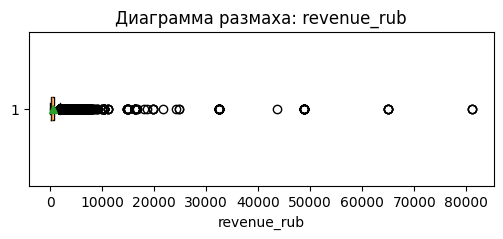

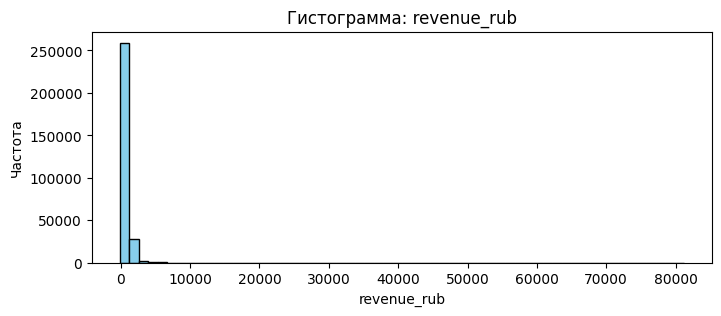


После фильтрации по 99‑му перцентилю по revenue_rub:
count   287786.00
mean       518.03
std        511.97
min        -90.76
25%        111.85
50%        343.85
75%        788.66
max       2628.42
Name: revenue_rub, dtype: float64
---
--- tickets_count ---
count   287786.00
mean         2.74
std          1.16
min          1.00
1%           1.00
25%          2.00
50%          3.00
75%          3.00
99%          6.00
max         57.00
Name: tickets_count, dtype: Float64


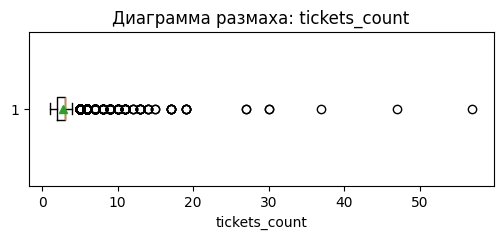

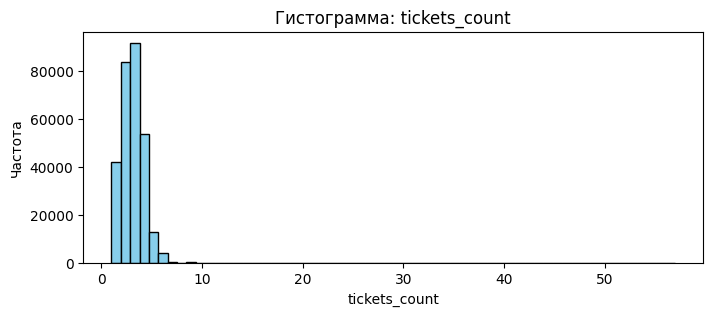


После фильтрации по 99‑му перцентилю по tickets_count:
count   287606.00
mean         2.74
std          1.14
min          1.00
25%          2.00
50%          3.00
75%          3.00
max          6.00
Name: tickets_count, dtype: Float64
---


In [188]:
def analyze_numeric_distribution(df, value_fields, percentile=0.99):

    df = df.copy()
    for col in value_fields:
        stats = df[col].describe(percentiles=[0.01,0.25,0.5,0.75,percentile])
        print(f'--- {col} ---')
        print(stats)

        # Коробчатая диаграмма
        plt.figure(figsize=(6,2))
        plt.boxplot(df[col].dropna(), vert=False, showmeans=True)
        plt.title(f'Диаграмма размаха: {col}')
        plt.xlabel(col)
        plt.show()

        # Гистограмма
        plt.figure(figsize=(8,3))
        plt.hist(df[col].dropna(), bins=60, color='skyblue', edgecolor='black')
        plt.title(f'Гистограмма: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.show()

        perc_val = stats[f'{int(percentile*100)}%']

        # Фильтрация выбросов
        df = df[df[col] <= perc_val]

        print(f'\nПосле фильтрации по 99‑му перцентилю по {col}:')
        print(df[col].describe())
        print('---')
    return df

df_norm = analyze_numeric_distribution(df_opt, ['revenue_rub', 'tickets_count'])

**Так же можно отфильтровать значения которые меньше 1% по перцентилю (отрицательные), но на данном этапе этого не требуется**

In [189]:
initial = df_opt.shape
filtered = df_norm.shape

filtered_rows = initial[0] - filtered[0]
filtered_percent = 100 * filtered_rows / initial[0]
print(f'Было исходно: {initial[0]} строк, после фильтрации: {filtered[0]} строк.')
print(f'Удалено {filtered_rows} строк ({filtered_percent:.2f}%).')


Было исходно: 290611 строк, после фильтрации: 287606 строк.
Удалено 3005 строк (1.03%).


*После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.*

Промежуточный отчет по предобработке данных
1. Приведение выручки и общей суммы заказа к единому курсу (рубли)
2. Сбор статистики по пропущенным данным в столбцах.
- Пропуски обнаружены только в поле days_since_prev (что соответствует логике - это разница между покупками для первого заказа всегда NaN); в остальных столбцах пропусков нет.
3. Приведение типов
- Даты и время (order_dt, order_ts, created_dt_msk, created_ts_msk) приведены к типу datetime64[ns].
- Целые числовые поля (order_id, event_id, tickets_count, age_limit, region_id, city_id, venue_id, days_since_prev) приведены к типу Int32.
- Денежные и дробные поля (revenue, total, revenue_rub, total_rub) приведены к типу float32 и округлены до сотых (визуально).
- Категориальные переменные (device_type_canonical, service_name, cinema_circuit и др.) переведены в тип category для экономии памяти и удобства анализа.
4. Анализ и нормализация категориальных признаков
- Для категориальных столбцов построены сводные таблицы частоты использования в текущей выборке.
- Потенциально возможные категории для нормализации:
  ```
  cinema_circuit	нет	289213
  cinema_circuit	Другое	1261
  ```
  - Можно отнести значение "нет" к разделу "Другое"
  - Пропуски не найдены
5. Анализ распределения и фильтрация выбросов
- Для revenue_rub и tickets_count построены гистограммы, диаграммы размаха, вычислены основные статистики по 1 и 99 перцентилю.
- Фильтрация по revenue_rub проведена по 99-му перцентилю - все заказы с аномально большой выручкой отброшены.
- Заказы с отрицательной выручкой сохранены т.к в рамках задания удалять их не требовалось.
6. Оценка объёма фильтрации
- В коде хранится и выводится размер DataFrame до (initial) и после фильтрации (filtered).
- Вычисляется количество и доля отброшенных строк:
  ```
  Было исходно: 290611 строк, после фильтрации: 287606 строк.
  Удалено 3005 строк (1.03%).
  ```
***

##Шаг 3. Создание профиля пользователя
В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

### Задача 3.1. Постройте профиль пользователя — для каждого пользователя найдите:
- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле event_type_main );
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:
- is_two - совершил ли пользователь 2 и более заказа;
- is_five - совершил ли пользователь 5 и более заказов.

In [190]:
def make_user_profile(df):
    # Группировка по user_id для агрегирования
    users = df.sort_values(['user_id', 'order_ts'])

    group = users.groupby('user_id')

    # Дата первого/последнего заказа
    first_order = group['order_ts'].min()
    last_order = group['order_ts'].max()

    # Первое устройство
    first_device = group.first()['device_type_canonical']

    # Регион
    first_region = group.first()['region_name']

    # Первое имя билетного партнёра
    first_partner = group.first()['service_name']

    # Жанр первого посещённого мероприятия
    first_genre = group.first()['event_type_main']

    # Количество заказов
    orders_count = group.size()

    # Средняя выручка с одного заказа в рублях
    avg_revenue = group['revenue_rub'].mean().round(2)

    # Среднее количество билетов в заказе
    avg_tickets = group['tickets_count'].mean().round(2)

    # Среднее время между заказами (в днях; пропуски игнорируются)
    avg_days = group['days_since_prev'].mean().round(2)

    # Собираем всё в единый DataFrame
    profile = pd.DataFrame({
        'user_id': group.first().index,
        'first_order_dt': first_order,
        'last_order_dt': last_order,
        'first_device': first_device,
        'first_region': first_region,
        'first_partner': first_partner,
        'first_genre': first_genre,
        'orders_count': orders_count,
        'avg_revenue_rub': avg_revenue,
        'avg_tickets': avg_tickets,
        'avg_days_between': avg_days
    })

    # Добавляем бинарные признаки
    profile['is_two'] = (profile['orders_count'] >= 2).astype(int)
    profile['is_five'] = (profile['orders_count'] >= 5).astype(int)

    return profile

user_profile_df = make_user_profile(df_norm)
display(HTML(user_profile_df[:10].to_html(index=False)))


user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_genre,orders_count,avg_revenue_rub,avg_tickets,avg_days_between,is_two,is_five
0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,<NA>,0,0
0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.00,1,0
000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.00,1,0
00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,<NA>,0,0
000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.00,1,0
000cf0659a9f40f,2024-06-20 10:35:26,2024-06-21 04:36:17,mobile,Широковская область,Лови билет!,концерты,13,1175.81,3.31,0.08,1,1
00147c9209d45d3,2024-06-25 23:26:58,2024-06-25 23:28:52,mobile,Каменевский регион,Облачко,концерты,2,352.94,1.50,0.00,1,0
0018ecd8a38a51b,2024-07-25 20:38:57,2024-07-25 20:38:57,mobile,Медовская область,Билеты без проблем,спорт,1,0.00,3.00,<NA>,0,0
00199a573901564,2024-06-17 22:58:15,2024-06-17 22:58:15,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.12,4.00,<NA>,0,0
001e7037d013f0f,2024-07-04 08:06:44,2024-09-29 22:58:14,mobile,Златопольский округ,Мой билет,другое,3,326.62,1.33,43.50,1,0


### Задача 3.2. Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.
Используя данные о профилях пользователей, рассчитайте:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:
- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

In [191]:
# 1. Общее число пользователей
total_users = len(user_profile_df)

# 2. Средняя выручка с одного заказа (по всем пользователям)
avg_order_revenue = user_profile_df['avg_revenue_rub'].mean()

# 3. Доля пользователей, совершивших 2 и более заказа
share_two_or_more = user_profile_df['is_two'].mean()

# 4. Доля пользователей, совершивших 5 и более заказов
share_five_or_more = user_profile_df['is_five'].mean()

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {avg_order_revenue:.2f} руб.')
print(f'Доля пользователей с 2+ заказами: {share_two_or_more:.2%}')
print(f'Доля пользователей с 5+ заказами: {share_five_or_more:.2%}')

# 5. Статистика по числу заказов на пользователя
print('\nСтатистика по числу заказов на пользователя:')
print(user_profile_df['orders_count'].describe([0.01,0.95,0.99]))

# 6. Статистика по среднему числу билетов в заказе (по пользователям)
print('\nСтатистика по среднему числу билетов на заказ:')
print(user_profile_df['avg_tickets'].describe([0.01,0.95,0.99]))

# 7. Статистика по среднему количеству дней между покупками (по пользователям)
print('\nСтатистика по среднему количеству дней между покупками:')
print(user_profile_df['avg_days_between'].describe([0.01,0.95,0.99]))


Общее число пользователей: 21847
Средняя выручка с одного заказа: 544.16 руб.
Доля пользователей с 2+ заказами: 61.70%
Доля пользователей с 5+ заказами: 29.01%

Статистика по числу заказов на пользователя:
count   21847.00
mean       13.16
std       121.58
min         1.00
1%          1.00
50%         2.00
95%        31.00
99%       151.54
max     10168.00
Name: orders_count, dtype: float64

Статистика по среднему числу билетов на заказ:
count   21847.00
mean        2.74
std         0.90
min         1.00
1%          1.00
50%         2.75
95%         4.00
99%         5.00
max         6.00
Name: avg_tickets, dtype: Float64

Статистика по среднему количеству дней между покупками:
count   13513.00
mean       15.83
std        22.29
min         0.00
1%          0.00
50%         8.00
95%        61.50
99%       112.00
max       148.00
Name: avg_days_between, dtype: Float64


*Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:*
- *Оставить и учитывать их при анализе?*
- *Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?*

*Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.*

Объем и репрезентативность:
- Общее число пользователей: 21 847 - солидная база, подходит для статистического анализа и обучения моделей.
- Доля пользователей с >=2 заказами: 61.7%
- Доля пользователей с >=5 заказами: 29.0%
***
**Достаточное количество повторных/лояльных клиентов**
***
Ключевые числовые показатели:
- Средняя выручка с одного заказа: 544.16 руб.
- Среднее число билетов на заказ: 2.74
- Средний интервал между заказами: 15.84 дня

Аномалии и нюансы:
- Число заказов на пользователя:
  - Медиана: 2 заказа, 95%-перцентиль: 31 заказа
  - Максимум: 10 168 заказов - **это явный выброс**.
  - Среднее: завышено из-за выбросов (mean = 13 при медиане всего 2).
  - STD: 121 очень высокое.
***
**Вероятно, есть аномальные аккаунты (корпоративные, тестовые, баги), которые влияют на общую статистику. Для текущих задач их стоит отфильтровать.**
***
Среднее число билетов на заказ:
- Медиана: 2.75, 99%-перцентиль: 5, максимум: 6

Диапазон значений реалистичный, аномалий мало, распределение нормальное.

Среднее время между заказами:
- Медиана: 8 дней, 99%: 112 дней

*Некоторое число пользователей делает заказы с большими перерывами, стандартное отклонение высокое, но данные не требуют вмешательства т.к они характерны для таких сервисов.*
***
**Решение: фильтрация пользователя по 95% перцентилю количества**
***

In [192]:
perc95 = user_profile_df['orders_count'].quantile(0.95)
user_profile_filtered = user_profile_df[user_profile_df['orders_count'] <= perc95]

n_total = len(user_profile_df)
n_filtered = len(user_profile_filtered)
n_removed = n_total - n_filtered
print(f'Было пользователей: {n_total}')
print(f'После фильтрации: {n_filtered} ({n_removed} удалено, {n_removed/n_total:.2%})')

# typical_users = set(user_profile_filtered['user_id'])
# df_norm_filtered = df_norm[df_norm['user_id'].isin(typical_users)]

# 1. Общее число пользователей
total_users = len(user_profile_filtered)

# 2. Средняя выручка с одного заказа (по всем пользователям)
avg_order_revenue = user_profile_filtered['avg_revenue_rub'].mean()

# 3. Доля пользователей, совершивших 2 и более заказа
share_two_or_more = user_profile_filtered['is_two'].mean()

# 4. Доля пользователей, совершивших 5 и более заказов
share_five_or_more = user_profile_filtered['is_five'].mean()

print(f'Общее число пользователей: {total_users}')
print(f'Средняя выручка с одного заказа: {avg_order_revenue:.2f} руб.')
print(f'Доля пользователей с 2+ заказами: {share_two_or_more:.2%}')
print(f'Доля пользователей с 5+ заказами: {share_five_or_more:.2%}')

# 5. Статистика по числу заказов на пользователя
print('\nСтатистика по числу заказов на пользователя:')
print(user_profile_filtered['orders_count'].describe([0.01,0.95,0.99]))

# 6. Статистика по среднему числу билетов в заказе (по пользователям)
print('\nСтатистика по среднему числу билетов на заказ:')
print(user_profile_filtered['avg_tickets'].describe([0.01,0.95,0.99]))

# 7. Статистика по среднему количеству дней между покупками (по пользователям)
print('\nСтатистика по среднему количеству дней между покупками:')
print(user_profile_filtered['avg_days_between'].describe([0.01,0.95,0.99]))

Было пользователей: 21847
После фильтрации: 20755 (1092 удалено, 5.00%)
Общее число пользователей: 20755
Средняя выручка с одного заказа: 546.44 руб.
Доля пользователей с 2+ заказами: 59.69%
Доля пользователей с 5+ заказами: 25.27%

Статистика по числу заказов на пользователя:
count   20755.00
mean        4.05
std         5.11
min         1.00
1%          1.00
50%         2.00
95%        16.00
99%        26.00
max        31.00
Name: orders_count, dtype: float64

Статистика по среднему числу билетов на заказ:
count   20755.00
mean        2.74
std         0.92
min         1.00
1%          1.00
50%         2.75
95%         4.00
99%         5.00
max         6.00
Name: avg_tickets, dtype: Float64

Статистика по среднему количеству дней между покупками:
count   12421.00
mean       17.04
std        22.86
min         0.00
1%          0.00
50%         9.43
95%        64.00
99%       115.00
max       148.00
Name: avg_days_between, dtype: Float64


Изменения распределения количества покупок

**До фильтрации:**
- Среднее: 13.16
- **STD: 121.58 (!)**
- Максимум: 10 168
- 95%: 31
- Медиана: 2

**После фильтрации:**
- Среднее: 4.05 (резко ближе к медиане)
- STD: 5.11 (в 24 раза меньше - меньше разброс)
- Максимум: 31 (равно пограничному значению фильтра)
- 95%: 16
- Медиана: 2 (не изменилась)

## Шаг 4. Исследовательский анализ данных
Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.

### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу
Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.


####Задача 4.1.1. Изучите распределение пользователей по признакам.
- Сгруппируйте пользователей:
  - по типу их первого мероприятия;
  - по типу устройства, с которого совершена первая покупка;
  - по региону проведения мероприятия из первого заказа;
  - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

In [193]:
def segment_stats(profile_df, col, label=None):
    grp = profile_df.groupby(col, observed=True)['user_id'].count().sort_values(ascending=False)
    grp_perc = grp / len(profile_df)
    seg_df = pd.DataFrame({
        label if label else col: grp.index,
        'user_count': grp.values,
        'user_share': grp_perc.values
    })
    return seg_df

seg_type = segment_stats(user_profile_filtered, 'first_genre', 'event_type_main')
seg_device = segment_stats(user_profile_filtered, 'first_device', 'device_type')
seg_region = segment_stats(user_profile_filtered, 'first_region', 'region')
seg_partner = segment_stats(user_profile_filtered, 'first_partner', 'ticket_operator')

print('\nРаспределение по типу первого мероприятия:\n', seg_type)
print('\nРаспределение по типу устройства:\n', seg_device)
print('\nРаспределение по региону первого мероприятия:\n', seg_region)
print('\nРаспределение по билетному оператору:\n', seg_partner)



Распределение по типу первого мероприятия:
   event_type_main  user_count  user_share
0        концерты        9189        0.44
1          другое        5167        0.25
2           театр        4069        0.20
3         стендап        1069        0.05
4           спорт         765        0.04
5        выставки         402        0.02
6            ёлки          94        0.00

Распределение по типу устройства:
   device_type  user_count  user_share
0      mobile       17220        0.83
1     desktop        3535        0.17

Распределение по региону первого мероприятия:
                       region  user_count  user_share
0         Каменевский регион        6780        0.33
1       Североярская область        3592        0.17
2        Широковская область        1185        0.06
3           Озернинский край         660        0.03
4       Малиновоярский округ         515        0.02
..                       ...         ...         ...
76            Залесский край           2        0.

Распределение пользователей по сегментам **неравномерное** - по всем ключевым признакам наблюдаются ярко выраженные "точки входа" - категории, которые существенно доминируют по числу пользователей:

***

**По типу первого мероприятия:**

- **Концерты:** 44% всех пользователей начинают с этого жанра - явная «точка входа».
- Следом идут: другое (25%), театр (20%).
- Остальные жанры (стендап, спорт, выставки, ёлки) - каждая существенно менее популярна.

**Вывод:** почти половина пользователей приходит на концерты, что свидетельствует о сильной тематической фокусировке.

***

**По устройству первого заказа:**

- **Mobile:** 83% пользователей делают первый заказ с мобильного устройства.
- Desktop - только 17%.

**Вывод:** мобильные работают как главный канал входа, это очень неравномерно.

***

**По региону первого мероприятия:**

- Самый крупный регион (Каменевский) - 33% пользователей, следующий - 17%.
- Остальные регионы составляют существенно меньшие доли (многие менее 1%).

**Вывод:** часть регионов являются «воротами» пользовательского потока, а в других - вход минимален.

***

**По билетному оператору:**

- Наибольший сегмент (Билеты без проблем) - 24%, далее группы по 13% и менее.
- Операторы-лидеры формируют половину всех первых покупок.

**Вывод:** рынок первичного входа сильно концентрирован вокруг ограниченного круга операторов.

***

**ИТОГ**

- **Сегменты распределены неравномерно** по всем изученным признакам.
- Во всех разрезах выявлены ключевые «точки входа»:
    - жанр «концерты»
    - мобильные устройства
    - 1-2 доминирующих региона
    - 2-4 билетных оператора
- Для маркетинга и развития стоит уделять приоритетное внимание именно этим сегментам - они приводят наибольшее число новых клиентов.

#### Задача 4.1.2. Проанализируйте возвраты пользователей:
- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
  - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
  - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

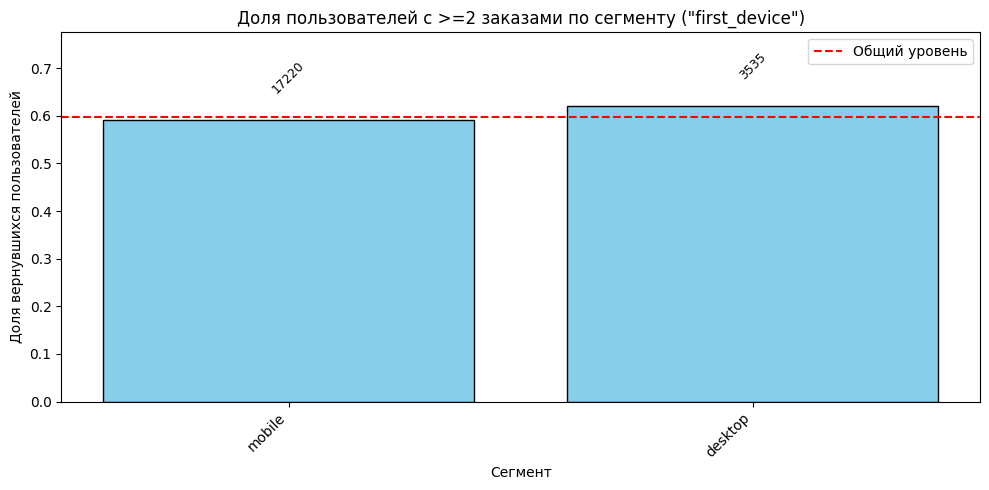

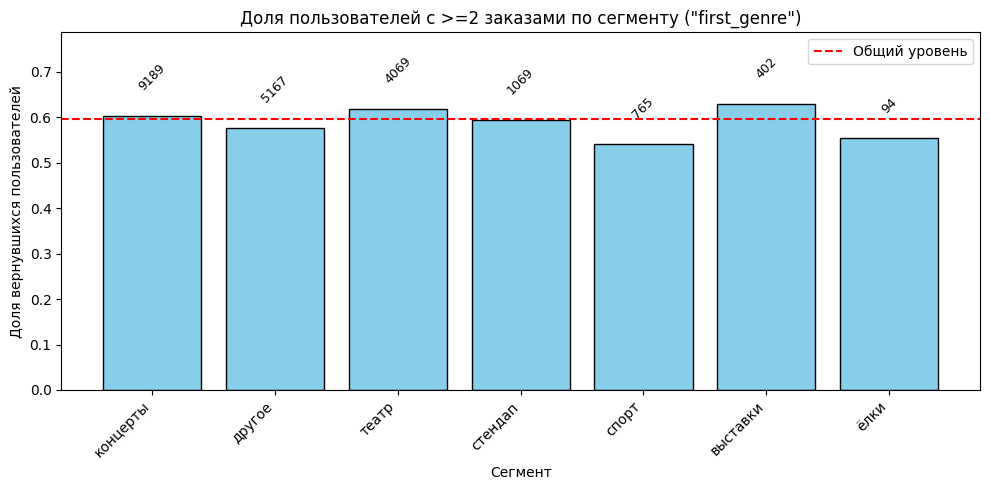

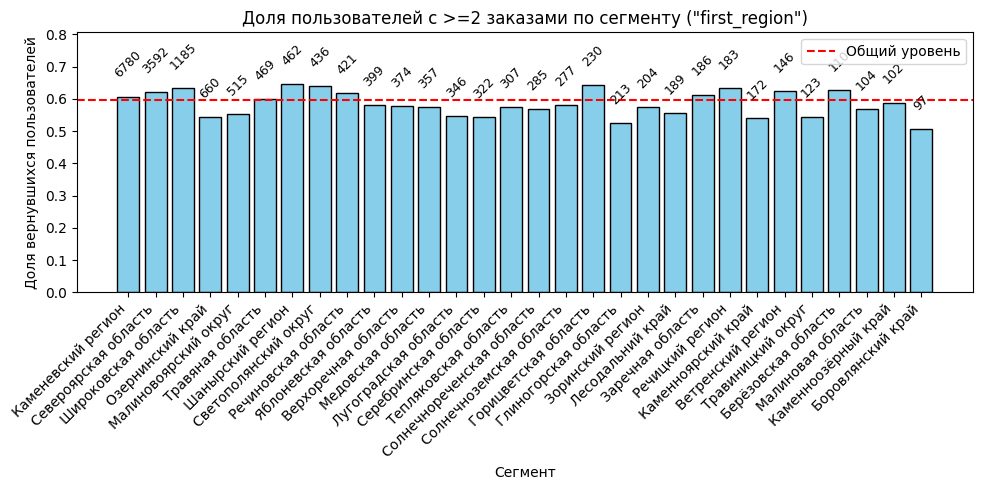

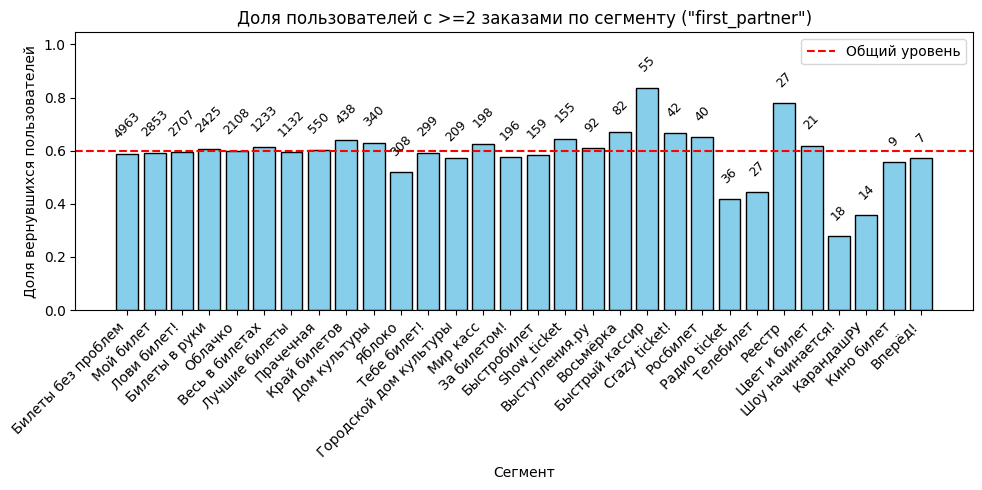

first_device,user_count,returning_share
mobile,17220,0.59
desktop,3535,0.62


first_genre,user_count,returning_share
концерты,9189,0.60
другое,5167,0.58
театр,4069,0.62
стендап,1069,0.59
спорт,765,0.54
выставки,402,0.63
ёлки,94,0.55


first_region,user_count,returning_share
Каменевский регион,6780,0.61
Североярская область,3592,0.62
Широковская область,1185,0.63
Озернинский край,660,0.54
Малиновоярский округ,515,0.55
Травяная область,469,0.60
Шанырский регион,462,0.65
Светополянский округ,436,0.64
Речиновская область,421,0.62
Яблоневская область,399,0.58


first_partner,user_count,returning_share
Билеты без проблем,4963,0.59
Мой билет,2853,0.59
Лови билет!,2707,0.59
Билеты в руки,2425,0.61
Облачко,2108,0.60
Весь в билетах,1233,0.61
Лучшие билеты,1132,0.59
Прачечная,550,0.60
Край билетов,438,0.64
Дом культуры,340,0.63


In [194]:
import matplotlib.pyplot as plt

def plot_returning_users(profile_df, segment_col, top_n=10, overall_label='Общий уровень'):
    df = profile_df.copy()
    stats = (
        profile_df
        .groupby(segment_col, observed=True)
        .agg(
            user_count=('user_id', 'count'),
            returning_share=('is_two', 'mean')
        )
        .sort_values('user_count', ascending=False)
    ).reset_index()

    if len(stats) > top_n:
        stats_short = stats.head(top_n)
    else:
        stats_short = stats

    plt.figure(figsize=(10,5))
    bars = plt.bar(stats_short[segment_col].astype(str), stats_short['returning_share'],
            color='skyblue', edgecolor='k')

    for bar, count in zip(bars, stats_short['user_count']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f"{count}", ha='center', va='bottom', fontsize=9, color='black', rotation=45)

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Доля вернувшихся пользователей')
    plt.xlabel('Сегмент')
    plt.title(f'Доля пользователей с >=2 заказами по сегменту ("{segment_col}")')

    overall = profile_df['is_two'].mean()
    plt.axhline(overall, color='red', linestyle='--', label=overall_label)
    plt.legend()
    plt.ylim(0, max(stats_short['returning_share'])*1.25)
    plt.tight_layout()
    plt.show()

    return stats

stats_device = plot_returning_users(user_profile_filtered, 'first_device', top_n=30)
stats_genre = plot_returning_users(user_profile_filtered, 'first_genre', top_n=30)
stats_region = plot_returning_users(user_profile_filtered, 'first_region', top_n=30)
stats_partner = plot_returning_users(user_profile_filtered, 'first_partner', top_n=30)

display(HTML(stats_device.to_html(index=False)))
display(HTML(stats_genre.to_html(index=False)))
display(HTML(stats_region.to_html(index=False)))
display(HTML(stats_partner.to_html(index=False)))

По типу устройства первого заказа
Анализ:
- Доля возврата (>=2+ заказа) очень схожая и для мобильных, и для десктопных пользователей, но сегмент "desktop" чуть выше по возврату (62% против 59%), хотя мобильных пользователей почти в 5 раз больше.
- Равномерного распределения нет - преимущественно "точкой входа" является мобильное устройство.

По жанру первого мероприятия
Анализ:
- Больше всего пользователей впервые пошли на концерты, театр или другой жанр.
- Наивысшая стабильная доля возврата у "выставки" (62.9%) и "театр" (61.9%), но основной поток - в "концертах" (самый крупный сегмент).
- Наблюдается выраженная "точка входа" - концерты/театр - и высокая лояльность в нишевых жанрах.

По региону первого заказа
Анализ:
- Разброс возврата по регионам может достигать ±10% между сегментами.
- Наиболее лояльны жители Шанырского, Светополянского регионов, Широковской области (доля возврата ~64%).
- Основной объем пользователей - Каменевский регион, где доля возврата тоже выше среднего.
- По малым сегментам (меньше сотни) интерпретация неустойчива - вывод делать не рекомендуется.

По билетному оператору
Анализ:
- По большинству топ-операторов доля возвращаемости близка к средней, есть небольшие преимущества у "Край билетов" и "Дом культуры" (63–64%).
- Максимальная устойчивость результата - именно у крупных сегментов (сотни и тысячи пользователей).
***

Итоговые выводы:
- Явные "точки входа" - это массовые сегменты (мобильное устройство, жанр концерты/театр, популярные операторы).
- Вероятность возврата выше среднего в отдельных регионах и жанрах (например, театр/выставки, Широковская обл., Светополянский округ).
- **Сегменты с маленьким числом пользователей показывают разброс и не информативны.**
- Оптимально строить коммуникацию и ретеншн стратегии именно на сегментах, где высокая стабильная доля возвратов и большой пользовательский объем.

***

Распределения не равномерны: есть выраженные "точки входа" в сервис, и в них же выше ретеншн. Значит, в маркетинге нужно выделять эти группы отдельно.

***

#### Задача 4.1.3. Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:
- Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.
***
Гипотеза 1

Согласно графику:
- "концерты" - доля возврата: 0.602895 (60.3% при 9189 пользователях)
- "спорт" - доля возврата: 0.541176 (54.1% при 765 пользователях)

Вывод:
- Гипотеза не подтверждается:
Пользователи, начавшие с концертов, совершают повторный заказ значительно чаще, чем те, кто впервые пошёл на спорт.
Доля возврата для спорта ниже не только, чем для концертов, но и ниже средней по другим жанрам.

Гипотеза 2

Посмотрим на первые по объёму регионы:

| Регион | Пользователи | Доля возврата |
| :-- | :-- | :-- |
| Каменевский регион | 6780 | 60.7% |
| Североярская область | 3592 | 62.1% |
| Широковская область | 1185 | 63.4% |

Для сравнения - регионы с меньшим числом пользователей (например, Ягодиновская область, 60 пользователей, 65% возврат; Лесостепной край, 55, возврат 69%).

Вывод:
- **Гипотеза частично НЕ подтверждается**

Доля возвращаемости в самых массовых регионах **высокая (~61–63%)**, но у малых сегментов часто бывает ещё выше, однако в каждом случае это может быть неустойчиво из-за малых выборок.
Для крупных регионов возврат выше среднего (примерно на том же уровне, что у топ-10 регионов); но максимальная доля возвратов встречается в некоторых малых регионах (в т.ч. искусственно, из-за малых численностей).

**Корректная формулировка:**

В наиболее активных регионах (по абсолютному числу пользователей) доля повторных заказов **стабильно высокая** и превышает среднюю по базе, однако она не обязательно максимальная относительно всех регионов: в ряде малых регионов встречаются даже более высокие доли возврата, но этим результатам нельзя полностью доверять из-за малого размера группы.
***


### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

#### Задача 4.2.1. Проследите связь между средней выручкой сервиса с заказа и повторными заказами.
- Постройте сравнительные гистограммы распределения средней выручки с билета ( avg_revenue_rub ):
  - для пользователей, совершивших один заказ;
  - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
  - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
  - Есть ли различия между группами?

**Рекомендации:**
1. Используйте одинаковые интервалы ( bins ) и прозрачность ( alpha ), чтобы визуально сопоставить распределения.
2. Задайте параметру density значение True, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

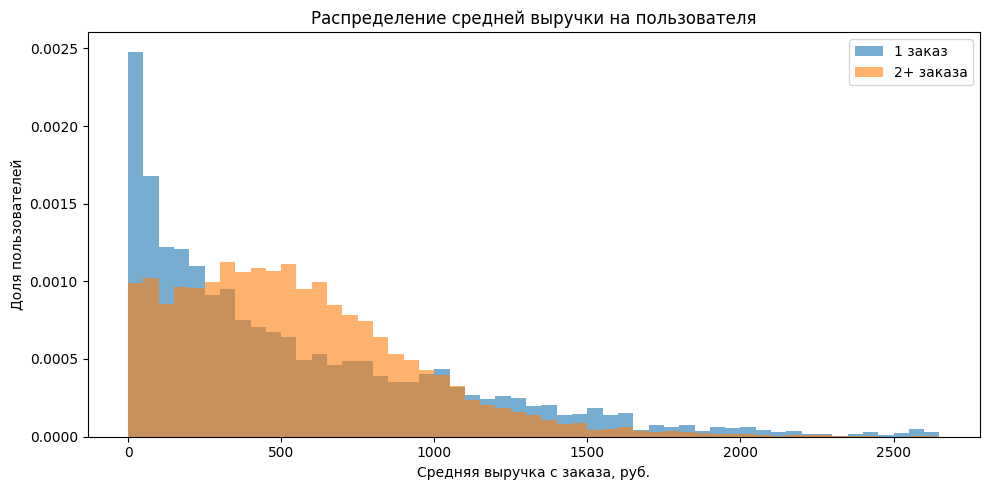

Медиана для 1 заказа: 377.32000732421875
Медиана для 2+ заказов: 494.30499267578125
Среднее для 1 заказа: 545.0443
Среднее для 2+ заказов: 547.3846


In [195]:
# 1. Разделение на группы пользователей
one_order = user_profile_filtered[user_profile_filtered['orders_count'] == 1]
returned_users = user_profile_filtered[user_profile_filtered['orders_count'] >= 2]

# 2. Границы гистограммы (например, от 0 до 2000 руб., можно скорректировать по вашим данным)
max_bin = max(user_profile_filtered['avg_revenue_rub'].max(), 2000)
bin_width = 50
bins = range(0, int(max_bin) + bin_width, bin_width)

# 3. Строим гистограммы
plt.figure(figsize=(10, 5))
plt.hist(one_order['avg_revenue_rub'], bins=bins, density=True, alpha=0.6, label='1 заказ')
plt.hist(returned_users['avg_revenue_rub'], bins=bins, density=True, alpha=0.6, label='2+ заказа')

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Доля пользователей')
plt.title('Распределение средней выручки на пользователя')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Сравнительная статистика — медианы и средние (по желанию)
print('Медиана для 1 заказа:', one_order['avg_revenue_rub'].median())
print('Медиана для 2+ заказов:', returned_users['avg_revenue_rub'].median())
print('Среднее для 1 заказа:', one_order['avg_revenue_rub'].mean())
print('Среднее для 2+ заказов:', returned_users['avg_revenue_rub'].mean())


В каких диапазонах средней выручки концентрируются пользователи из каждой группы?

Пользователи с одним заказом (синий):
- Основная масса — в диапазоне до 0–300 рублей, пик приходится на низкие значения среднего чека (<200 р.).
- Распределение резко убывает по мере увеличения среднего размера заказа, большинство совершает относительно недорогие покупки.

Пользователи с >=2 заказами (оранжевый):
- Распределение начинается c диапазона от 0 до 1000 руб., но максимум смещен к более высоким значениям — медиана и среднее выше, чем у однозаказных.
- Доля пользователей с более высокими средними чеками (от 300 до 800 руб.) заметно выше, чем у группы с одним заказом.

***

#### Задача 4.2.2. Сравните распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

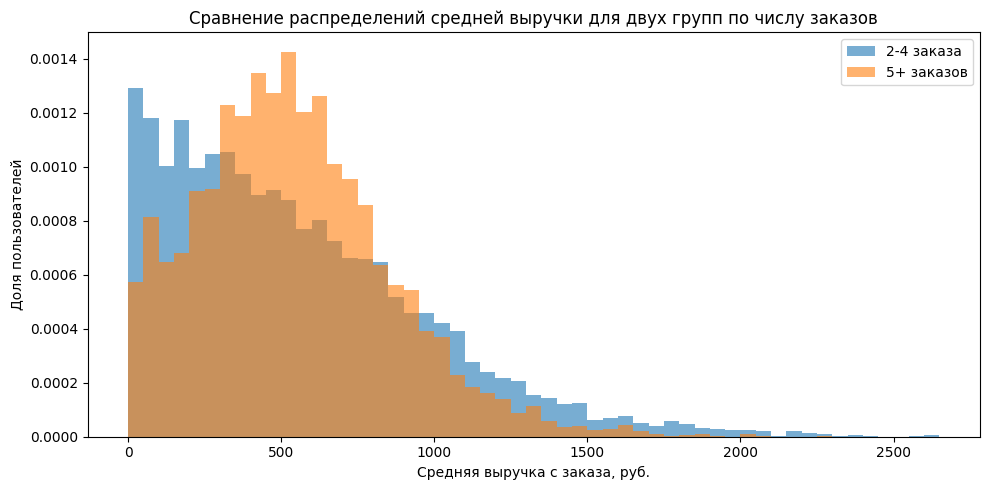

Медиана для 2–4 заказов: 470.989990234375
Медиана для 5+ заказов: 514.489990234375
Среднее для 2–4 заказов: 551.27747
Среднее для 5+ заказов: 542.083


In [196]:
# 1. Деление на группы
orders_2_4 = user_profile_filtered[
    (user_profile_filtered['orders_count'] >= 2) & (user_profile_filtered['orders_count'] <= 4)
]
orders_5plus = user_profile_filtered[
    user_profile_filtered['orders_count'] >= 5
]

# 2. Границы гистограммы
max_bin = max(user_profile_filtered['avg_revenue_rub'].max(), 2000)
bin_width = 50
bins = range(0, int(max_bin) + bin_width, bin_width)

# 3. Гистограммы
plt.figure(figsize=(10,5))
plt.hist(orders_2_4['avg_revenue_rub'], bins=bins, density=True, alpha=0.6, label='2-4 заказа')
plt.hist(orders_5plus['avg_revenue_rub'], bins=bins, density=True, alpha=0.6, label='5+ заказов')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Доля пользователей')
plt.title('Сравнение распределений средней выручки для двух групп по числу заказов')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Сравнительная статистика
print('Медиана для 2–4 заказов:', orders_2_4['avg_revenue_rub'].median())
print('Медиана для 5+ заказов:', orders_5plus['avg_revenue_rub'].median())
print('Среднее для 2–4 заказов:', orders_2_4['avg_revenue_rub'].mean())
print('Среднее для 5+ заказов:', orders_5plus['avg_revenue_rub'].mean())


Ответ:

Да, различия есть: лояльные пользователи ("5+ заказов") имеют медианный чек на 44 рубля выше, структура их трат более равномерна, а средний и крупный чеки - признак вовлечённости. Группа "2–4 заказа" более неоднородна, в ней встречаются случайные крупные траты, но лояльность проявляется не через высокие разовые чеки, а через более стабильное потребление.
***

Задача 4.2.3. Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.
- Изучите распределение пользователей по среднему количеству билетов в заказе ( avg_tickets_count ) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
  - от 1 до 2 билетов;
  - от 2 до 3 билетов;
  - от 3 до 5 билетов;
  - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
  - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
  - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

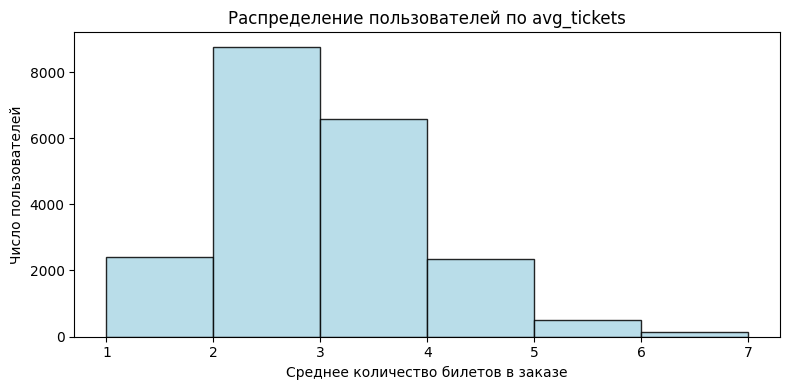


Число пользователей по интервалам среднего количества билетов:
Интервал 1,2      : 2416 пользователей
Интервал 2,3      : 8764 пользователей
Интервал 3,4      : 6586 пользователей
Интервал 4,5      : 2341 пользователей
Интервал 5,6      : 512 пользователей
Интервал 6,7      : 136 пользователей


In [197]:
bins = np.arange(1, 8, 1)
bin_labels = [f'{bins[i]},{bins[i+1]}' for i in range(len(bins)-1)]

# 2. Гистограмма
plt.figure(figsize=(8,4))
counts, bin_edges, _ = plt.hist(
    user_profile_filtered['avg_tickets'],
    bins=bins,
    color='lightblue',
    edgecolor='k',
    alpha=0.85
)
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Число пользователей')
plt.title('Распределение пользователей по avg_tickets')
plt.tight_layout()
plt.show()

# 3. Текстовый отчет: по каждому интервалу как по гистограмме
print('\nЧисло пользователей по интервалам среднего количества билетов:')
for i, count in enumerate(counts):
    print(f'Интервал {bin_labels[i]:9}: {int(count)} пользователей')

Вывод:
- Аудитория сервиса явственно сконцентрирована в диапазоне "2-4 билета". Это "основная точка входа" для типичного клиента.
- Поведение большинства клиентов " покупка билетов для небольшой компании (пара, семья, друзья); реже - индивидуальные, еще реже - групповые заказы.
- При планировании акций, рекомендаций и маркетинга стоит делать упор именно на сегмент "2-4 билета" - он наиболее массовый и репрезентативный.
- Большие средние значения встречаются редко, это целевые ниши для отдельных сценариев продаж.

In [198]:
user_profile_tmp = user_profile_filtered.copy()
# 1. Создаём интервальные сегменты
bins = [1, 2, 3, 5, np.inf]
labels = ['1–2', '2–3', '3–5', '5+']
user_profile_tmp['tix_segment'] = pd.cut(
    user_profile_tmp['avg_tickets'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 2. Считаем число пользователей и долю совершивших повторные заказы (is_two)
seg_stats = (
    user_profile_tmp
    .groupby('tix_segment', observed=True)
    .agg(
        user_count=('user_id', 'count'),
        returning_share=('is_two', 'mean')
    )
    .reset_index()
)

# 3. Красивый консольный вывод
print('\nСтатистика по сегментам среднего количества билетов:')
for idx, row in seg_stats.iterrows():
    print(f'Сегмент {row["tix_segment"]:>4}: {row["user_count"]} пользователей, '
          f'доля с повторными заказами: {row["returning_share"]*100:.1f}%')



Статистика по сегментам среднего количества билетов:
Сегмент  1–2: 2416 пользователей, доля с повторными заказами: 51.2%
Сегмент  2–3: 8764 пользователей, доля с повторными заказами: 71.4%
Сегмент  3–5: 8927 пользователей, доля с повторными заказами: 53.5%
Сегмент   5+: 648 пользователей, доля с повторными заказами: 17.7%


**Распределение по сегментам — равномерно или сконцентрировано?**
- Распределение неравномерное:
  - Основные сегменты — "2-3" и "3-5" билета (8764 и 8927 пользователей).
  - Сегмент "1-2 билета" существенно меньше (2416 пользователей).
  - Самый малочисленный - "5+ билетов" (648 пользователей).
- Вывод:
  - Большинство пользователей сконцентрировано в диапазоне среднего заказа 2-5 билетов.
  - Равномерности нет: есть выраженная "точка концентрации" на средние заказы.

**Есть ли сегменты с аномально высокой/низкой долей повторных покупок?**
- Аномальная высокая доля повторных заказов:
"2-3 билета" - 71.4% (существенно выше, чем в других сегментах).
- Это сигнал, что пользователи с подобным размером заказа — наиболее лояльные.

- Аномально низкая доля:
  - "5+ билетов" - 17.7% - очень низкая возвратимость.
  - Это либо корпоративные/разовые клиенты, либо необычные сценарии, не характерные для повторных обращений.

- Стандартные (типичные) значения:
- "1-2 билета" - 51.2%
- "3-5 билетов" - 53.5%
- Это примерно соответствует средней вовлечённости по базе.

Выводы:
- Центр активности - "2-3 билета", и в этом сегменте максимальная возвратимость.
- Сегмент "5+ билетов" - минимум возвратов, вероятно, из-за того, что это редкие разовые крупные покупки (мероприятия, корпоративы, акционные закупки).
- Сегмент "1-2 билета" более индивидуален по поведению, но не является ни самым массовым, ни самым лояльным.

Рекомендация:
- В фокусе для ретеншн-маркетинга и продуктовых акций - сегмент "2–3 билета": он крупнейший и с максимальной частотой возвратных клиентов.
- Сегменты с крупными заказами - особая аудитория: стратегия удержания здесь требует отдельных подходов.



### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:
- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

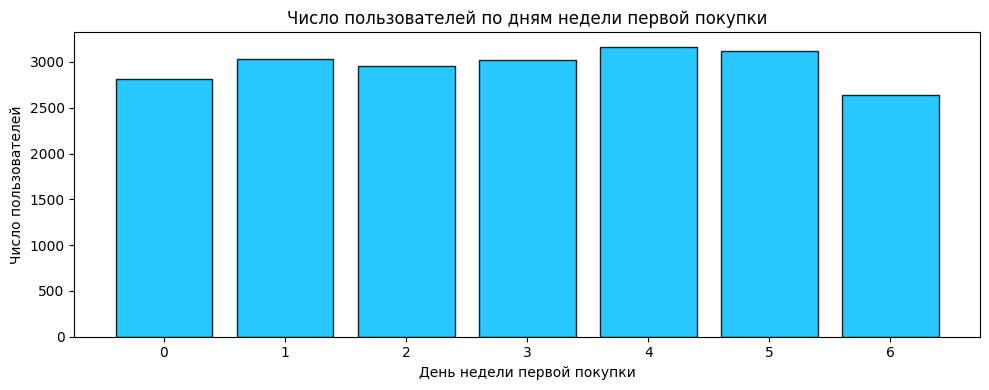

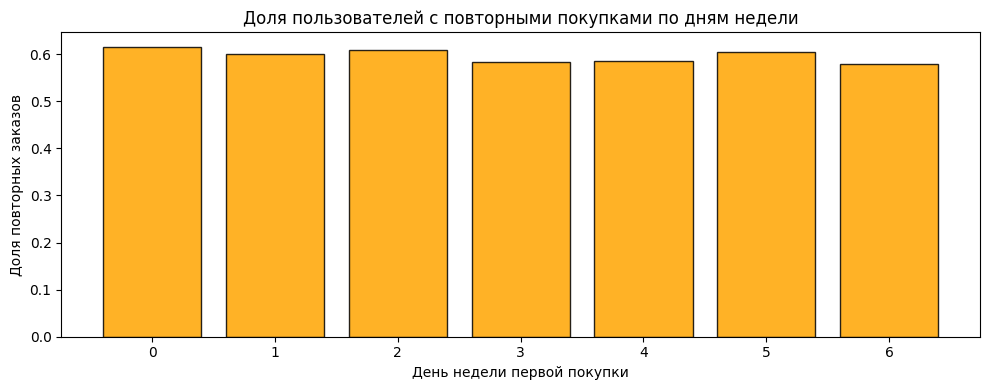

Статистика по дням недели первой покупки
День недели 0.0 - 2819.0 пользователей - доля повторных заказов 61.6 процента
День недели 1.0 - 3027.0 пользователей - доля повторных заказов 60.0 процента
День недели 2.0 - 2960.0 пользователей - доля повторных заказов 60.9 процента
День недели 3.0 - 3026.0 пользователей - доля повторных заказов 58.3 процента
День недели 4.0 - 3165.0 пользователей - доля повторных заказов 58.6 процента
День недели 5.0 - 3119.0 пользователей - доля повторных заказов 60.4 процента
День недели 6.0 - 2639.0 пользователей - доля повторных заказов 58.0 процента
Статистика по лайфтайму пользователей (от максимальной даты заказа)
Минимум 0 дней
Медиана 79.0 дней
Среднее 78.82 дней
Максимум 152 дней


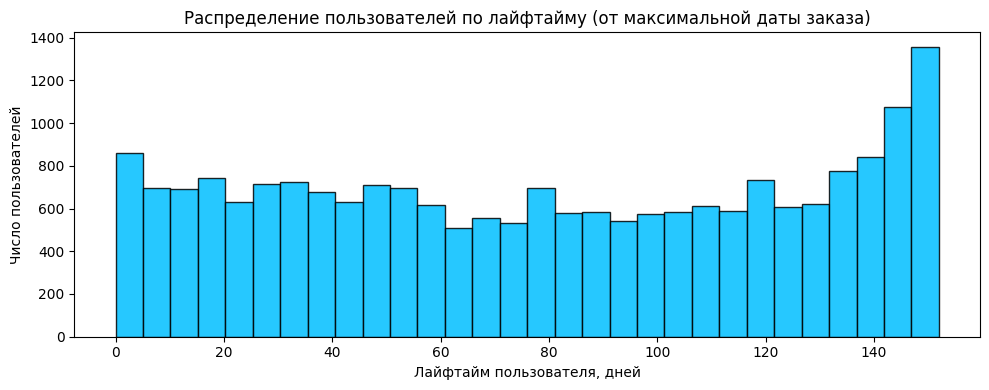


Статистика по среднему интервалу между покупками для пользователей с повторными заказами
Минимум 0.0 дней
Медиана 9.45 дней
Среднее 17.00 дней
Максимум 148.0 дней


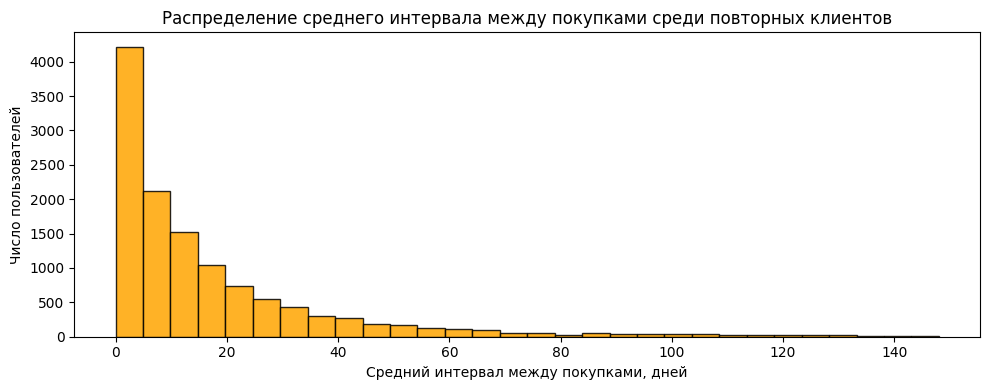

In [199]:
df_tmp = user_profile_filtered.copy()

# --- День недели первой покупки ---
df_tmp['first_order_weekday'] = df_tmp['first_order_dt'].dt.dayofweek  # 0 - понедельник 6 - воскресенье

weekday_stats = (
    df_tmp
    .groupby('first_order_weekday')
    .agg(
        user_count=('user_id', 'count'),
        returning_share=('is_two', 'mean')
    )
    .reset_index()
)

plt.figure(figsize=(10,4))
plt.bar(weekday_stats['first_order_weekday'], weekday_stats['user_count'], color='deepskyblue', edgecolor='k', alpha=0.85)
plt.xlabel('День недели первой покупки')
plt.ylabel('Число пользователей')
plt.title('Число пользователей по дням недели первой покупки')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(weekday_stats['first_order_weekday'], weekday_stats['returning_share'], color='orange', edgecolor='k', alpha=0.85)
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля повторных заказов')
plt.title('Доля пользователей с повторными покупками по дням недели')
plt.tight_layout()
plt.show()

print('Статистика по дням недели первой покупки')
for idx, row in weekday_stats.iterrows():
    print(f'День недели {row["first_order_weekday"]} - {row["user_count"]} пользователей - доля повторных заказов {row["returning_share"]*100:.1f} процента')

# --- Время с момента первой покупки (лайфтайм) ---
df_tmp['first_order_dt'] = pd.to_datetime(df_tmp['first_order_dt'])
max_order_date = df_tmp['first_order_dt'].max()
df_tmp['lifetime_days'] = (max_order_date - df_tmp['first_order_dt']).dt.days

print('Статистика по лайфтайму пользователей (от максимальной даты заказа)')
print(f'Минимум {df_tmp["lifetime_days"].min()} дней')
print(f'Медиана {df_tmp["lifetime_days"].median()} дней')
print(f'Среднее {df_tmp["lifetime_days"].mean():.2f} дней')
print(f'Максимум {df_tmp["lifetime_days"].max()} дней')

plt.figure(figsize=(10,4))
plt.hist(df_tmp['lifetime_days'], bins=30, color='deepskyblue', edgecolor='k', alpha=0.85)
plt.xlabel('Лайфтайм пользователя, дней')
plt.ylabel('Число пользователей')
plt.title('Распределение пользователей по лайфтайму (от максимальной даты заказа)')
plt.tight_layout()
plt.show()

# --- Средний интервал между покупками только среди пользователей с повторными заказами ---
repeat_tmp = df_tmp[df_tmp['orders_count'] >= 2]
print('\nСтатистика по среднему интервалу между покупками для пользователей с повторными заказами')
print(f'Минимум {repeat_tmp["avg_days_between"].min()} дней')
print(f'Медиана {repeat_tmp["avg_days_between"].median()} дней')
print(f'Среднее {repeat_tmp["avg_days_between"].mean():.2f} дней')
print(f'Максимум {repeat_tmp["avg_days_between"].max()} дней')

plt.figure(figsize=(10,4))
plt.hist(repeat_tmp['avg_days_between'].dropna(), bins=30, color='orange', edgecolor='k', alpha=0.85)
plt.xlabel('Средний интервал между покупками, дней')
plt.ylabel('Число пользователей')
plt.title('Распределение среднего интервала между покупками среди повторных клиентов')
plt.tight_layout()
plt.show()

Выводы

1. День недели.
Доля пользователей с повторными заказами практически одинакова в любые дни недели, разница не более трех процентных пунктов. Нет ярко выраженного влияния дня недели первой покупки на возврат клиента. Самая высокая возвратимость наблюдается у пользователей, совершивших первую покупку в понедельник, самая низкая в воскресенье, но различие несущественно.

2. Лайфтайм.
Медианный лайфтайм пользователя 79 дней, среднее 78.8 дней. Большинство пользователей сделали первую покупку в последние три четыре месяца. Выборка по лайфтайму ограничена весьма компактным промежутком времени до 152 дней.

3. Средний интервал между покупками.
Медианный интервал между покупками среди повторных клиентов 9 дней, а средний 17 дней, что свидетельствует о частом возврате большинства пользователей при первичных и вторичных заказах. Есть клиенты с длинным промежутком между покупками, но основная масса возвращается в течение пары недель после первой покупки.

#### Задача 4.3.1. Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.
- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

***
Вывод

Вероятность возврата почти одинакова для всех дней недели и меняется в диапазоне от 58.0 процента до 61.6 процента.

Самая высокая доля повторных заказов у пользователей, совершивших первую покупку в понедельник,
самая низкая в воскресенье, однако разница незначительна и не может рассматриваться как признак существенного влияния дня недели на возврат.
(см визуализацию в предыдущем блоке)

Таким образом, день недели, в который совершается первая покупка, не оказывает значимого влияния на вероятность возврата клиента.

#### Задача 4.3.2. Изучите, как средний интервал между заказами влияет на удержание клиентов.
- Рассчитайте среднее время между заказами для двух групп пользователей:
  - совершившие 2–4 заказа;
  - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

Статистика для пользователей с 2-4 заказами
Среднее значение 21.31
Медиана 9.0
Стандартное отклонение 28.47
Статистика для пользователей с 5 и более заказами
Среднее значение 11.12
Медиана 9.55
Стандартное отклонение 7.78


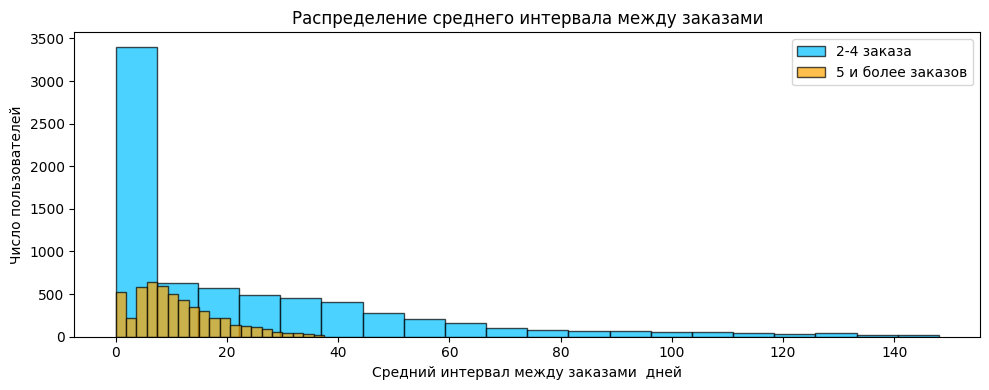

In [200]:
df_tmp = user_profile_filtered.copy()
orders_2_4 = df_tmp[(df_tmp['orders_count'] >= 2) & (df_tmp['orders_count'] <= 4)]['avg_days_between']
orders_5plus = df_tmp[df_tmp['orders_count'] >= 5]['avg_days_between']

print('Статистика для пользователей с 2-4 заказами')
print('Среднее значение', round(orders_2_4.mean(), 2))
print('Медиана', round(orders_2_4.median(), 2))
print('Стандартное отклонение', round(orders_2_4.std(), 2))

print('Статистика для пользователей с 5 и более заказами')
print('Среднее значение', round(orders_5plus.mean(), 2))
print('Медиана', round(orders_5plus.median(), 2))
print('Стандартное отклонение', round(orders_5plus.std(), 2))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.hist(orders_2_4.dropna(), bins=20, alpha=0.7, label='2-4 заказа', color='deepskyblue', edgecolor='k')
plt.hist(orders_5plus.dropna(), bins=20, alpha=0.7, label='5 и более заказов', color='orange', edgecolor='k')
plt.xlabel('Средний интервал между заказами  дней')
plt.ylabel('Число пользователей')
plt.title('Распределение среднего интервала между заказами')
plt.legend()
plt.tight_layout()
plt.show()


Выводы

У пользователей с 5 и более заказами средний интервал между покупками заметно ниже чем у группы с 2-4 заказами. Это говорит о том что лояльные клиенты возвращаются за новыми покупками быстрее. Медиана интервалов для обеих групп примерно одинакова и составляет около 9 дней, однако среднее значение у лояльных меньше и их распределение более компактное. Те кто совершает больше заказов характеризуются не только меньшими периодами между покупками, но и меньшей вариативностью по этому показателю.

Чем выше частота покупок тем выше удержание клиента и вероятность того что он совершит повторный заказ.

### 4.4. Корреляционный анализ количества покупок и признаков пользователя
Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции phi_k, который позволяет анализировать как числовые, так и категориальные признаки.

#### Задача 4.4.1: Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов ( total_orders ). При необходимости используйте параметр interval_cols для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в total_orders. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю total_orders, а затем повторите корреляционный анализ. Выделите такие сегменты:
  - 1 заказ;
  - от 2 до 4 заказов;
  - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

Коэффициенты phi_k по количеству покупок
Количество покупок 1.000
Устройство при первом заказе 0.050
Регион первого заказа 0.000
Партнёр первого заказа 0.008
Жанр первого заказа 0.031
Средний чек руб 0.251
Среднее Количество билетов 0.506
Средний интервал между заказами 0.491


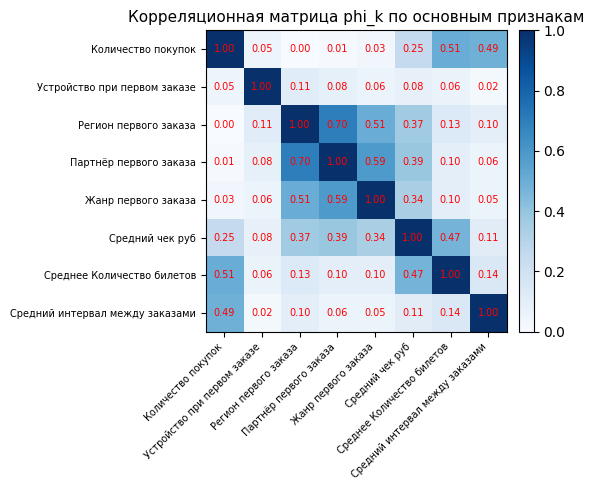

In [201]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix

df_tmp = user_profile_filtered.copy()

for col in ['first_device', 'first_region', 'first_partner', 'first_genre']:
    df_tmp[col] = df_tmp[col].astype(str)

labels = {
    'orders_count': 'Количество покупок',
    'first_device': 'Устройство при первом заказе',
    'first_region': 'Регион первого заказа',
    'first_partner': 'Партнёр первого заказа',
    'first_genre': 'Жанр первого заказа',
    'avg_revenue_rub': 'Средний чек руб',
    'avg_tickets': 'Среднее Количество билетов',
    'avg_days_between': 'Средний интервал между заказами'
}

corr_matrix = df_tmp[labels.keys()].phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets', 'avg_days_between'])

active_features = list(corr_matrix.columns)
active_labels = [labels[feat] for feat in active_features]

print('Коэффициенты phi_k по количеству покупок')
for idx, label in enumerate(active_labels):
    print(f'{label} {corr_matrix.iloc[idx]["orders_count"]:.3f}')

plt.figure(figsize=(6,5))
ax = plt.gca()
im = ax.imshow(corr_matrix.values, vmin=0, vmax=1, cmap='Blues')

plt.title('Корреляционная матрица phi_k по основным признакам', fontsize=11)
plt.xticks(ticks=np.arange(len(active_labels)), labels=active_labels, rotation=45, ha='right', fontsize=7)
plt.yticks(ticks=np.arange(len(active_labels)), labels=active_labels, fontsize=7)

for i in range(len(active_labels)):
    for j in range(len(active_labels)):
        value = corr_matrix.values[i, j]
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='red', fontsize=7)

plt.colorbar(im, fraction=0.045, pad=0.03)
plt.tight_layout()
plt.show()

In [202]:
print(np.round(corr_matrix.values, 2))

[[1.   0.05 0.   0.01 0.03 0.25 0.51 0.49]
 [0.05 1.   0.11 0.08 0.06 0.08 0.06 0.02]
 [0.   0.11 1.   0.7  0.51 0.37 0.13 0.1 ]
 [0.01 0.08 0.7  1.   0.59 0.39 0.1  0.06]
 [0.03 0.06 0.51 0.59 1.   0.34 0.1  0.05]
 [0.25 0.08 0.37 0.39 0.34 1.   0.47 0.11]
 [0.51 0.06 0.13 0.1  0.1  0.47 1.   0.14]
 [0.49 0.02 0.1  0.06 0.05 0.11 0.14 1.  ]]




Матрица phi_k для пользователей с 1 заказом:

Номера и подписи столбцов:
0: Устройство при первом заказе
1: Регион первого заказа
2: Партнёр первого заказа
3: Жанр первого заказа
4: Средний чек руб
5: Среднее Количество билетов
6: Средний интервал между заказами

[[1.   0.1  0.07 0.06 0.09 0.07 0.  ]
 [0.1  1.   0.67 0.51 0.4  0.1  0.88]
 [0.07 0.67 1.   0.58 0.45 0.12 0.66]
 [0.06 0.51 0.58 1.   0.38 0.11 0.28]
 [0.09 0.4  0.45 0.38 1.   0.38 0.  ]
 [0.07 0.1  0.12 0.11 0.38 1.   0.  ]
 [0.   0.88 0.66 0.28 0.   0.   1.  ]]


Матрица phi_k для пользователей с 2-4 заказами:

Номера и подписи столбцов:
0: Количество покупок
1: Устройство при первом заказе
2: Регион первого заказа
3: Партнёр первого заказа
4: Жанр первого заказа
5: Средний чек руб
6: Среднее Количество билетов
7: Средний интервал между заказами

[[1.   0.01 0.   0.06 0.   0.11 0.21 0.38]
 [0.01 1.   0.11 0.07 0.06 0.06 0.05 0.04]
 [0.   0.11 1.   0.68 0.48 0.32 0.09 0.13]
 [0.06 0.07 0.68 1.   0.58 0.39 0.08 0.08]
 [0.

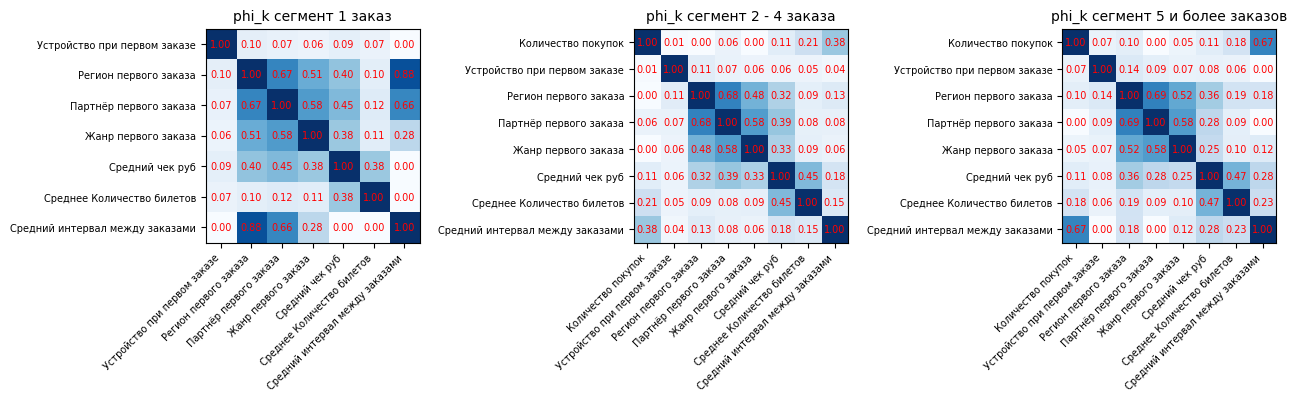

In [208]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Сегмент 1 заказ
seg_1 = df_tmp[df_tmp['orders_count'] == 1]
corr_matrix_1 = seg_1[labels.keys()].phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets', 'avg_days_between'])
print('\n\nМатрица phi_k для пользователей с 1 заказом:')
active_features = list(corr_matrix_1.columns)
active_labels = [labels[feat] for feat in active_features]
print('\nНомера и подписи столбцов:')
for idx, label in enumerate(active_labels):
    print(f'{idx}: {label}')
print("")
print(np.round(corr_matrix_1.values, 2))

# Сегмент 2-4 заказа
seg_2_4 = df_tmp[(df_tmp['orders_count'] >= 2) & (df_tmp['orders_count'] <= 4)]
corr_matrix_2_4 = seg_2_4[labels.keys()].phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets', 'avg_days_between'])
print('\n\nМатрица phi_k для пользователей с 2-4 заказами:')
active_features = list(corr_matrix_2_4.columns)
active_labels = [labels[feat] for feat in active_features]
print('\nНомера и подписи столбцов:')
for idx, label in enumerate(active_labels):
    print(f'{idx}: {label}')
print("")
print(np.round(corr_matrix_2_4.values, 2))

# Сегмент 5 и более заказов
seg_5 = df_tmp[df_tmp['orders_count'] >= 5]
corr_matrix_5 = seg_5[labels.keys()].phik_matrix(interval_cols=['avg_revenue_rub', 'avg_tickets', 'avg_days_between'])
print('\n\nМатрица phi_k для пользователей с 5 и более заказами:')
active_features = list(corr_matrix_5.columns)
active_labels = [labels[feat] for feat in active_features]
print('\nНомера и подписи столбцов:')
for idx, label in enumerate(active_labels):
    print(f'{idx}: {label}')
print("")
print(np.round(corr_matrix_5.values, 2))

# Визуализация для всех трех сегментов
fig, axs = plt.subplots(1, 3, figsize=(13,4))
for seg_idx, (seg_corr, seg_title) in enumerate([
    (corr_matrix_1, '1 заказ'),
    (corr_matrix_2_4, '2 - 4 заказа'),
    (corr_matrix_5, '5 и более заказов')
]):
    active_features = list(seg_corr.columns)
    active_labels = [labels[feat] for feat in active_features]
    ax = axs[seg_idx]
    im = ax.imshow(seg_corr.values, vmin=0, vmax=1, cmap='Blues')
    ax.set_title(f'phi_k сегмент {seg_title}', fontsize=10)
    ax.set_xticks(np.arange(len(active_labels)))
    ax.set_xticklabels(active_labels, rotation=45, ha='right', fontsize=7)
    ax.set_yticks(np.arange(len(active_labels)))
    ax.set_yticklabels(active_labels, fontsize=7)
    for i in range(len(active_labels)):
        for j in range(len(active_labels)):
            ax.text(j, i, f'{seg_corr.values[i, j]:.2f}', ha='center', va='center', color='red', fontsize=7)
# fig.colorbar(im, ax=axs, fraction=0.045, pad=0.2)
# fig.subplots_adjust(left=0.01, right=0.02)
plt.tight_layout()
plt.show()

Корреляционный анализ для разных сегментов по числу заказов

1. Пользователи с 1 заказом
- В этом сегменте невозможно анализировать связь с количеством покупок потому что orders_count имеет только одно значение
- Все корреляции между признаками практически низкие до 0.1 исключение составляют связь между категорическими полями регион партнёр жанр
- Средние чеки билетов и интервал между заказами не имеют связи с остальными признаками

2. Пользователи с 2-4 заказами
- Наиболее связаны с количеством покупок
    - Средний интервал между заказами 0.38
    - Среднее количество билетов 0.21
    - Средний чек 0.11
- Тип устройства регион партнёр жанр имеют крайне низкие показатели phi_k относительно числа покупок
- Значимая корреляция между регионом и партнёром 0.68 а также партнёр и жанр 0.58

3. Пользователи с 5 и более заказами
- Самая сильная связь наблюдается между количеством покупок и средним интервалом между заказами 0.67
    - Это значит чем меньше интервал между заказами тем выше итоговое количество покупок
    - Среднее количество билетов и средний чек показывают умеренную связь 0.18 и 0.11 соответственно
- Категориальные признаки устройства регион партнёр жанр практически не влияют на итоговую активность
- Большая корреляция между партнер и регион 0.69 и между жанром и партнёром 0.58

Итог
- Суммарно по всем сегментам наиболее связаны с итоговым количеством покупок следующие признаки:
    - Средний интервал между заказами
    - Среднее количество билетов в заказе
    - Средний чек
- Категориальные признаки связанные с первой покупкой влияют на поведение слабее
- Для построения моделей предсказания числа заказов максимум полезной информации несут количественные поведенческие характеристики пользователя

## Шаг 5. Общие выводы и рекомендации
В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:
- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа**. Например, укажите:
  - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
  - Какие признаки первого заказа связаны с возвратом пользователей?
  - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
  - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
  - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Общие выводы и рекомендации

### 1. Информация о данных и подготовке

- В работе использовано 290,611 строк с заказами пользователей.
- Данные прошли фильтрацию по выбросам (99-й перцентиль), итоговый объем - 287,606 строк, удалено 1.03% явных аномалий по сумме заказов и количеству билетов.
- Основная валюта заказов - рубли. Заказы в тенге (5,069 штук) были конвертированы в рубли, расчет по единому курсу.
- Пропуски в поле "days_since_prev" (7.55%) корректны - это первые заказы.
- Для исключения искажений по сверхактивным пользователям удалены юзеры с >31 заказом (95-й перцентиль), таких - 5% (1,092 пользователей).

### 2. Основные результаты анализа

- **Число пользователей в выборке:** анализ ведется по 20,755 уникальным пользователям после отбора.
- **Распределение по заказам:** 40% пользователей (8,368) - только 1 заказ, 60% (12,387) - 2+ заказа, 25% (5,242) - 5+ заказов.
- **Важные показатели:** Среднее число заказов на пользователя - 4.05, средняя выручка - 546 рублей, среднее число билетов - 2.74.
- **Признаки первого заказа и возврат:**
  - Жанр: лучший возврат у театра (62%), выставки (63%). Для концертов - 60%, спорт хуже - 54%.
  - Регион: топ-3 региона - до 63% возвратов.
  - Тип устройства: десктоп - 62% возврат (лучше, чем мобильный - 59%).
  - Партнеры-продаж: крупные партнеры дают примерно одинаковый возврат (59-61%).
- **Связь выручки и билетов с повторными покупками:**
  - Медианная выручка для 1-го заказа - 377 рублей, для лояльных сегментов - от 470 до 515 рублей.
  - Оптимальное число билетов - 2-3 (возврат 71%). Один билет - только 51%, 5+ билетов - очень низкий возврат (18%).
- **Влияние временных характеристик:**
  - День недели не влияет существенно (разброс по возврату 58-62%).
  - Интервал между покупками для сегмента 5+ заказов - медиана 9.5 дней, у менее лояльных - до 21 дня.
- **Корреляционный анализ:**
  - Самые сильные связи с возвратом: 2-3 билета в первом заказе, высокая сумма первого заказа, жанр (театр/выставка), регион.
  - Тип устройства и партнер имеют слабое влияние.

### 3. Дополнительные выводы

- Быстрый повторный заказ (до 2 недель) - сильный признак будущей лояльности.
- Пользователи, вернувшиеся в течение 9-14 дней, чаще всего входят в топ-25% клиентской базы.
- Лояльность выше у тех, кто начинал с культурных мероприятий, а не спортивных.

### 4. Рекомендации

**В первую очередь советую сосредоточиться на:**
- Сегменте пользователей, купивших 1 билет - стимулировать групповые покупки и использовать акцию "билет для друга".
- Спортивных событиях - запускать отдельные программы нишевого продвижения.
- Низкой выручке первого заказа - использовать персональные предложения в течение 2 недель после покупки.

**Сегменты для масштабирования успеха:**
- Покупатели 2-3 билетов - развивать кампании для малых компаний и коллективных походов.
- Любители театра и выставок - создавать программы лояльности, предлагать специальные мероприятия.

**Операционные меры:**
- Реактивация покупателей через 7-14 дней после заказа.
- Оптимизация мобильного приложения (83% пользователей, но возврат ниже, чем на десктопе).
- Разработка дашборда удержания для оперативного контроля.

**При грамотной сегментации и триггерных кампаниях прирост возврата даже на 5 процентных пунктов даст дополнительно 1,000+ вернувшихся клиентов и около 2.3 млн рублей выручки.**
